In [1]:
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepeare data set

In [4]:
dataset = get_dataset("electricity_nips", regenerate=False)

In [5]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [6]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [7]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/multivariate_grouper.py:106:

2014-01-14 01:00:00     93.317970
2014-01-14 02:00:00     92.165901
2014-01-14 03:00:00    101.958527
2014-01-14 04:00:00    104.262672
2014-01-14 05:00:00    104.838707
2014-01-14 06:00:00     95.046082
2014-01-14 07:00:00     91.013824
2014-01-14 08:00:00    107.718895
2014-01-14 09:00:00    199.308762
2014-01-14 10:00:00    157.834106
2014-01-14 11:00:00    172.811066
2014-01-14 12:00:00    167.050690
2014-01-14 13:00:00    150.345627
2014-01-14 14:00:00    173.387100
2014-01-14 15:00:00    198.156677
2014-01-14 16:00:00    181.451614
2014-01-14 17:00:00    150.345627
2014-01-14 18:00:00    128.456223
2014-01-14 19:00:00    129.608292
Freq: H, dtype: float32


/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


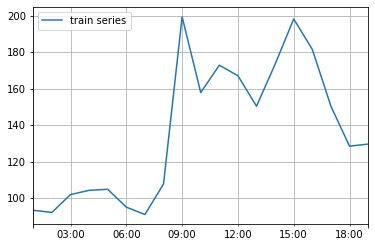

In [8]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas


entry = next(iter(dataset.train))
train_series = to_pandas(entry)
subset_data = train_series[1:20]
print(subset_data)
subset_data.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

## Evaluator

In [9]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

print(dataset.metadata)

freq='H' target=None feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='370')] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=24


## `GRU-Real-NVP`

In [10]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    flow_type='FlowPlusPlus',
    input_size='1484',
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    n_blocks=4,
    filters=16, 
    blocks=2, 
    components=4, 
    heads=2,
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [11]:
predictor = estimator.train(dataset_train)
# forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
#                                              predictor=predictor,
#                                              num_samples=100)
# forecasts = list(forecast_it)
# targets = list(ts_it)

# agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

hidden_size:  100
n_hidden:  2
conditioning_length:  200


  0%|          | 0/99 [00:00<?, ?it/s]

/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/nitinkumar/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning

torch.Size([64, 1, 48, 570])


RuntimeError: Given groups=1, weight of size [32, 128, 3, 3], expected input[64, 2, 48, 285] to have 128 channels, but got 2 channels instead

In [ ]:
# forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
#                                              predictor=predictor,
#                                              num_samples=100)
# forecasts = list(forecast_it)
# targets = list(ts_it)

# agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

### Metrics

In [ ]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

In [ ]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

## `GRU-MAF`

In [ ]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [ ]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

### Metrics

In [ ]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

In [ ]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

## `Transformer-MAF`

In [ ]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [ ]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

### Metrics

In [ ]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

In [ ]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))